# Рисование карты дефектов с помощью модели ver_10

In [1]:
# Подключенине библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import sys
sys.path.append('custom_modules')

import Data_processing as dp

from matplotlib import ticker
from IPython.display import display
from tensorflow import keras

### Константы для путей к файлам

In [2]:
# Пути к обработанным данным
# Путь к X части выборки с массивами в каждой ячейке
# Run1 - данные обучающей выборки
# Run2 - данные тестовой выборки
path_to_array_like_X_data = 'data/Prepared data/Run2/X_data_array_like.xlsx'
# Путь к Y части выборки
path_to_Y_data = 'data/Prepared data/Run2/Y_data(binary_classification).xlsx'


### Константы для обработки данных

In [3]:
# Размер кропа
PREP_image_size = 64
# Шаг кропа
PREP_crop_step = 5

In [4]:
# Детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

# Загрузка данных

In [5]:
# загрузка данных из файлов
X_dict = dict()
Y_dict = dict()

X_dict['df'] =  dp.get_array_like_X_df(path_to_array_like_X_data)
Y_dict['df'] =  dp.get_Y_df(path_to_Y_data)

# По желанию сдвиг по оси у
#shift = 100

#X_dict['df'] = pd.concat([X_dict['df'].iloc[:,shift:],X_dict['df'].iloc[:,:shift]],axis=1,ignore_index=True)
#Y_dict['df'] = pd.concat([Y_dict['df'].iloc[:,shift:],Y_dict['df'].iloc[:,:shift]],axis=1,ignore_index=True)

In [6]:
# Для последующей обработки сохраним
# начальные размеры считанных
# датафреймов
ORIG_df_cols = Y_dict['df'].shape[1]
ORIG_df_rows = Y_dict['df'].shape[0]

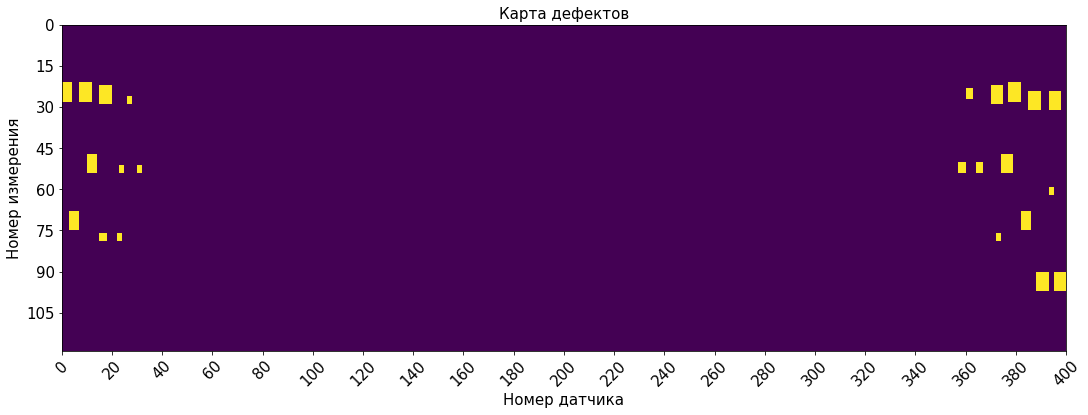

In [7]:
# Построить карту дефектов для считанного файла
# до всяких обработок
fig, axes = plt.subplots()

fig.set_figwidth(18)
fig.set_figheight(6)

axes.pcolormesh(Y_dict['df'])
axes.invert_yaxis()

axes.set_xlabel('Номер датчика', fontsize=15) 
axes.set_ylabel('Номер измерения', fontsize=15) 
axes.set_title(f'Карта дефектов', fontsize=15) 

#  Устанавливаем интервал основных делений: 
axes.xaxis.set_major_locator(ticker.MultipleLocator(20)) 
axes.yaxis.set_major_locator(ticker.MultipleLocator(15)) 
 
#  Устанавливаем форматирование чисел основных делений: 
axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
 
#  Устанавливаем форматирование делений: 
axes.xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45) 
axes.yaxis.set_tick_params(which = 'major', labelsize = 15) 

plt.show()

# Обработка данных

In [8]:
# Добавление строк в датафреймы
# Справа к каждому датафрейму дописывается по 64
# элемента, чтобы сымитировать сканирование 
# трубы по всей окружности фильтром размера 64 на 64
# а еще дописывается некоторое количество строк и столбцов
# меньшее чем шаг кропа. Чтобы датафрейм можно было поделить
# на целое кол-во кропов
print('||||||||||| X df preprocessing |||||||||||')
print('Original df size: ', X_dict['df'] .shape)
X_dict['df'] = pd.concat([X_dict['df'],X_dict['df'].iloc[:,:PREP_image_size]],axis=1,ignore_index=True)
X_dict['df'] = pd.concat([X_dict['df'],X_dict['df'].iloc[:PREP_image_size,:]],axis=0,ignore_index=True)
ADDED_df_rows = X_dict['df'].shape[0]
ADDED_df_cols = X_dict['df'].shape[1]
print('Result df size: ', X_dict['df'].shape)
X_dict['df'] = dp.reshape_df_for_future_crops(X_dict['df'], 
                                                        PREP_image_size, 
                                                        PREP_crop_step)
ADDED_df_rows = X_dict['df'].shape[0] - ADDED_df_rows
ADDED_df_cols = X_dict['df'].shape[1] - ADDED_df_cols


print('||||||||||| Y df preprocessing |||||||||||')
print('Original df size: ', Y_dict['df'].shape)
Y_dict['df'] = pd.concat([Y_dict['df'],Y_dict['df'].iloc[:,:PREP_image_size]],axis=1,ignore_index=True)
Y_dict['df'] = pd.concat([Y_dict['df'],Y_dict['df'].iloc[:PREP_image_size,:]],axis=0,ignore_index=True)
print('Original df size: ', Y_dict['df'].shape)
Y_dict['df'] = dp.reshape_df_for_future_crops(Y_dict['df'], 
                                                        PREP_image_size, 
                                                        PREP_crop_step)

print('\n')

||||||||||| X df preprocessing |||||||||||
Original df size:  (119, 400)
Result df size:  (183, 464)
||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (183, 464)
Crop windows height/width:  64
Crop windows step across rows and cols:  5
New df shape:  (184, 464)
||||||||||||||||||

||||||||||| Y df preprocessing |||||||||||
Original df size:  (119, 400)
Original df size:  (183, 464)
||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (183, 464)
Crop windows height/width:  64
Crop windows step across rows and cols:  5
New df shape:  (184, 464)
||||||||||||||||||





### Константы для обработки данных

In [9]:
# Запишем размеры датафреймов после обработки
PREP_df_cols = Y_dict['df'].shape[1]
PREP_df_rows = Y_dict['df'].shape[0]

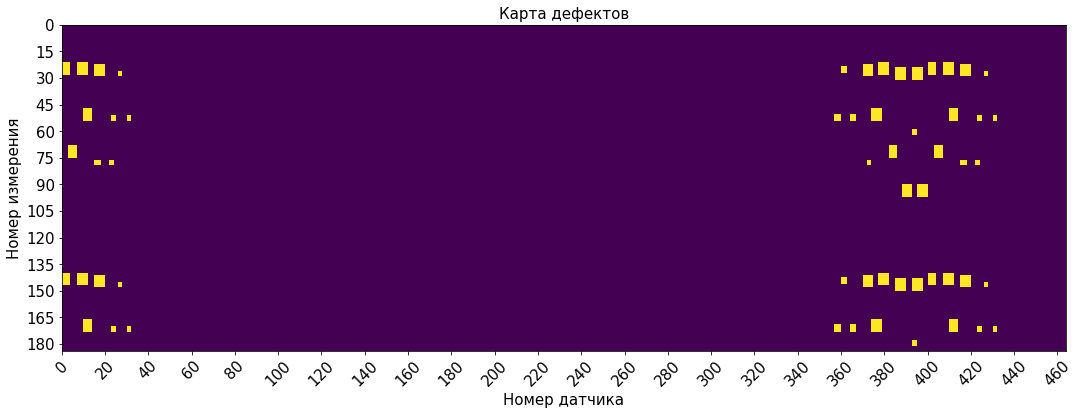

In [10]:
# Выведем карту дефектов после первичного расширения
fig, axes = plt.subplots()

fig.set_figwidth(18)
fig.set_figheight(6)

axes.pcolormesh(Y_dict['df'])
axes.invert_yaxis()
axes.set_xlabel('Номер датчика', fontsize=15) 
axes.set_ylabel('Номер измерения', fontsize=15) 
axes.set_title(f'Карта дефектов', fontsize=15) 

#  Устанавливаем интервал основных делений: 
axes.xaxis.set_major_locator(ticker.MultipleLocator(20)) 
axes.yaxis.set_major_locator(ticker.MultipleLocator(15)) 
 
#  Устанавливаем форматирование чисел основных делений: 
axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
 
#  Устанавливаем форматирование делений: 
axes.xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45) 
axes.yaxis.set_tick_params(which = 'major', labelsize = 15) 

plt.show()

In [11]:
# Запишем в словарь numpy array нарезанные из считанных датафреймов

print('||||||||||| X df preprocessing |||||||||||')
x_time_temp, \
x_amp_temp = dp.reshape_X_df_to_image_like_numpy(X_dict['df'], 
                                                    PREP_image_size, 
                                                    PREP_crop_step)
X_dict['X_time_all'] = x_time_temp.astype('float32')
X_dict['X_amp_all'] = x_amp_temp.astype('float32')

X_dict.pop('df',0)

print('||||||||||| Y df preprocessing |||||||||||')
y_temp = dp.reshape_Y_df_to_image_like_numpy(Y_dict['df'], 
                                             PREP_image_size, 
                                             PREP_crop_step)
Y_dict['Y_mask_all'] = y_temp.astype('int8')

Y_dict.pop('df',0)

print('\n')
    
    

||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
X df reshaping to 4D
Original df size:  (184, 464)
Crop windows height/width:  64
Crop windows step across rows and cols:  5
New X_time shape:  (2025, 64, 64, 32)
New X_amp shape:  (2025, 64, 64, 32)
||||||||||||||||||

||||||||||| Y df preprocessing |||||||||||
||||||||||||||||||
Y df reshaping to 3D
Original df size:  (184, 464)
Crop windows height/width:  64
Crop windows step across rows and cols:  5
New numpy shape:  (2025, 64, 64, 1)
||||||||||||||||||





In [12]:
print('|||||||||||||| X dataset ||||||||||||||||')
for key in X_dict.keys():
    print(f"{key}.shape: ", X_dict[key].shape)

print('\n|||||||||||||| Y dataset ||||||||||||||||')
for key in Y_dict.keys():
    print(f"{key}.shape: ", Y_dict[key].shape)

|||||||||||||| X dataset ||||||||||||||||
X_time_all.shape:  (2025, 64, 64, 32)
X_amp_all.shape:  (2025, 64, 64, 32)

|||||||||||||| Y dataset ||||||||||||||||
Y_mask_all.shape:  (2025, 64, 64, 1)


# CNN с 2 входами по времени и амплитуде

In [13]:
# Загрузка модели
model = keras.models.load_model('Networks//CNN//NetWork_(64x32+64x32)_to(1)_(test_0dot0366)_ver_10.h5')

In [14]:
# Предсказание модели
res = model.predict([X_dict['X_time_all'],X_dict['X_amp_all']])
print(res.shape)

64/64 [==============================] - 33s 507ms/step
(2025, 1)


In [15]:
# Преобразовать массив результатов работы модели размера (batch,1)
# в матрицу размера PREP_df_rows * PREP_df_cols (карту дефектов, построенную моделью)
# Размер выходной матрицы - PREP_df_rows * PREP_df_cols
# Так как начальное расширение датафрейма на PREP_image_size по 2 осям
# тут учитывается грубо, то размер выходной матрицы будет также
# PREP_df_rows * PREP_df_cols, а ячейки по конрутру будут размыты 
# и не точны, так как по ним фильтр прошел меньше раз чем по ячейкам 
# посреди матрицы

def reshape_2D_Y_numpy_to_2D(arr, rows_count, cols_count, crop_size, step = -1):

    print('||||||||||||||||||')
    print('Y arr reshaping to 2D')
    print('Original arr size: ', arr.shape)
    print('Crop windows height/width: ', crop_size)
    print('Crop windows step across rows and cols: ', step)

    if step == -1:
        step = crop_size
    
    new_arr = np.zeros((rows_count, cols_count))
    
    arr = arr[:,0]
    myit = iter(arr)    
    
    for j in range(0,  cols_count - crop_size + 1, step):
        for i in range(0, rows_count - crop_size + 1, step):
            temp_add = next(myit)
            temp_orig = new_arr[i:i+crop_size,j:j+crop_size]
            
            if temp_add > 0.5:
                temp_orig = temp_orig + 0.1
            if temp_add <= 0.5:
                temp_orig = temp_orig - 0.1
                
            '''ones_filter = temp_orig > 1
            zeros_filter = temp_orig < 0
            
            temp_orig[ones_filter] = 1
            temp_orig[zeros_filter] = 0'''
            
            new_arr[i:i+crop_size,j:j+crop_size] = temp_orig       
            
    print('New numpy shape: ', new_arr.shape)
    print('||||||||||||||||||\n')

    return new_arr

In [16]:
# Преобразовать массив результатов работы модели размера (batch,1)
# в матрицу размера ORIG_df_rows * ORIG_df_cols (карту дефектов, построенную моделью)
# Размер выходной матрицы - ORIG_df_rows * ORIG_df_cols
# Так как начальное расширение датафрейма на PREP_image_size по 2 осям
# тут учитывается хорошо, то размер выходной матрицы будет также
# ORIG_df_rows * ORIG_df_cols, а ячейки по конрутру не будут так размыты 
# и не точны, так как по ним фильтр прошел меньше раз чем по ячейкам 
# посреди матрицы

def reshape_2D_Y_numpy_to_2D_2(arr):

    print('||||||||||||||||||')
    print('Y arr reshaping to 2D')
    print('Crops arr size: ', arr.shape)
    print('Crop windows height/width: ', PREP_image_size)
    print('Crop windows step across rows and cols: ', PREP_crop_step)
    print(f'Orig map size: ({ORIG_df_rows},{ORIG_df_cols})')
    print(f'Added dims: ({ADDED_df_rows},{ADDED_df_cols})')
    print(f'Expanded map size: ({PREP_df_rows},{PREP_df_cols})')
    print()
    
    #ADDED_df_rows
    #ADDED_df_cols
    
    #ORIG_df_rows
    #ORIG_df_cols
    
    #PREP_df_rows
    #PREP_df_cols
    
    #PREP_image_size
    #PREP_crop_step

    new_arr = np.zeros((ORIG_df_rows, ORIG_df_cols))
    
    arr = arr[:,0]
    myit = iter(arr)    
    
    for j in range(0,  PREP_df_cols - PREP_image_size + 1, PREP_crop_step):
        for i in range(0, PREP_df_rows - PREP_image_size + 1, PREP_crop_step):
            temp_add_num = next(myit)
            if temp_add_num > 0.5:
                add_num = 0.1
            if temp_add_num <= 0.5:
                add_num = - 0.1

            if i <= ORIG_df_rows - PREP_image_size:
                if j <= ORIG_df_cols - PREP_image_size:
                    temp_orig = new_arr[i:i+PREP_image_size,j:j+PREP_image_size] + add_num
                    new_arr[i:i+PREP_image_size,j:j+PREP_image_size] = temp_orig  
                elif j <= ORIG_df_cols:
                    right_orig = new_arr[i:i+PREP_image_size,j:] + add_num
                    left_orig = new_arr[i:i+PREP_image_size,:PREP_image_size - right_orig.shape[1]] + add_num
                    new_arr[i:i+PREP_image_size,j:] = right_orig
                    new_arr[i:i+PREP_image_size,:PREP_image_size - right_orig.shape[1]] = left_orig

            elif i <= ORIG_df_rows:
                if j <= ORIG_df_cols - PREP_image_size:
                    low_orig = new_arr[i:,j:j+PREP_image_size] + add_num
                    high_orig = new_arr[:PREP_image_size - low_orig.shape[0],j:j+PREP_image_size] + add_num
                    new_arr[i:,j:j+PREP_image_size] = low_orig 
                    new_arr[:PREP_image_size - low_orig.shape[0],j:j+PREP_image_size] = high_orig 
                elif j <= ORIG_df_cols:
                    right_low = new_arr[i:,j:] + add_num
                    right_high = new_arr[:PREP_image_size - low_orig.shape[0],j:] + add_num
                    
                    left_low = new_arr[i:,:PREP_image_size - right_high.shape[1]] + add_num
                    left_high = new_arr[:PREP_image_size - low_orig.shape[0],:PREP_image_size - right_high.shape[1]] + add_num
                    
                    new_arr[i:,j:] = right_low
                    new_arr[:PREP_image_size - low_orig.shape[0],j:] = right_high
                    new_arr[i:,:PREP_image_size - right_high.shape[1]] = left_low
                    new_arr[:PREP_image_size - low_orig.shape[0],:PREP_image_size - right_high.shape[1]] = left_high
                    

        #new_arr[i:i+crop_size,j:j+crop_size] = temp_orig       
            
    print('New numpy shape: ', new_arr.shape)
    print('||||||||||||||||||\n')

    return new_arr

In [17]:
# Посчитаем карту дефектов на основании предсказаний модели 2 методами
map_1 = reshape_2D_Y_numpy_to_2D(res, PREP_df_rows, PREP_df_cols, PREP_image_size, PREP_crop_step)
map_2 = reshape_2D_Y_numpy_to_2D_2(res)

||||||||||||||||||
Y arr reshaping to 2D
Original arr size:  (2025, 1)
Crop windows height/width:  64
Crop windows step across rows and cols:  5
New numpy shape:  (184, 464)
||||||||||||||||||

||||||||||||||||||
Y arr reshaping to 2D
Crops arr size:  (2025, 1)
Crop windows height/width:  64
Crop windows step across rows and cols:  5
Orig map size: (119,400)
Added dims: (1,0)
Expanded map size: (184,464)

New numpy shape:  (119, 400)
||||||||||||||||||



# Построение карт дефектов моделью

## Грубое построение карты

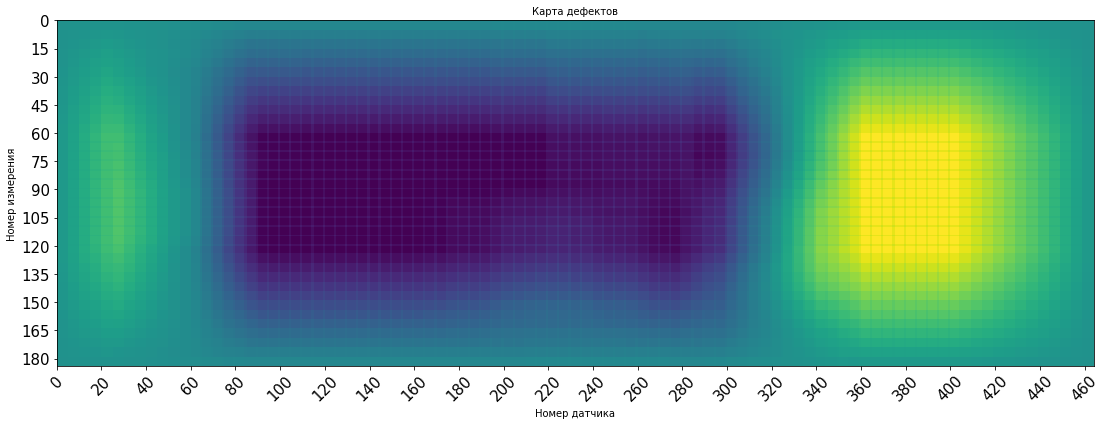

In [18]:
fig, axes = plt.subplots()

fig.set_figwidth(18)
fig.set_figheight(6)

axes.pcolormesh(map_1)
axes.invert_yaxis()
axes.set_xlabel('Номер датчика', fontsize=10) 
axes.set_ylabel('Номер измерения', fontsize=10) 
axes.set_title(f'Карта дефектов', fontsize=10) 

#  Устанавливаем интервал основных делений: 
axes.xaxis.set_major_locator(ticker.MultipleLocator(20)) 
axes.yaxis.set_major_locator(ticker.MultipleLocator(15)) 
 
#  Устанавливаем форматирование чисел основных делений: 
axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
 
#  Устанавливаем форматирование делений: 
axes.xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45) 
axes.yaxis.set_tick_params(which = 'major', labelsize = 15) 

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.2)
plt.show()

## Умное построение карты

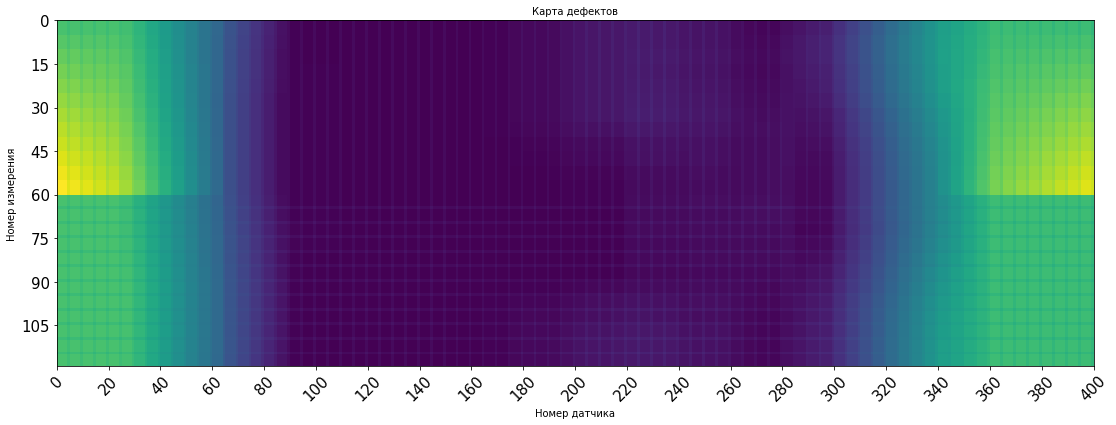

In [19]:
fig, axes = plt.subplots()

fig.set_figwidth(18)
fig.set_figheight(6)

axes.pcolormesh(map_2)
axes.invert_yaxis()
axes.set_xlabel('Номер датчика', fontsize=10) 
axes.set_ylabel('Номер измерения', fontsize=10) 
axes.set_title(f'Карта дефектов', fontsize=10) 

#  Устанавливаем интервал основных делений: 
axes.xaxis.set_major_locator(ticker.MultipleLocator(20)) 
axes.yaxis.set_major_locator(ticker.MultipleLocator(15)) 
 
#  Устанавливаем форматирование чисел основных делений: 
axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
 
#  Устанавливаем форматирование делений: 
axes.xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45) 
axes.yaxis.set_tick_params(which = 'major', labelsize = 15) 

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.2)
plt.show()